In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
 
path = "/content/gdrive/My Drive/Independent"
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
# 获取文本
import json

users_label = [] # 用户标签
users_posts = [] # 用户发言
index = 0    # 用户序号

# 读取文本
def read_text(file_path):
    global index

    text = open(file_path, 'r', encoding='UTF-8')
    line = text.readline()
    while line:
        if (len(line.strip()) != 0):
            setting = json.loads(line[1:-2])
            posts = setting['posts']
            label = setting['label']

            add_lable(label)
            add_posts(posts)

            index = index + 1
            line = text.readline()

        if (index == 1000):
            break

    return users_label, users_posts

# 记录用户标签
def add_lable(label):
    if (label == "depression"):
        users_label.append(1)
    else:
        users_label.append(0)

# 记录用户发言
def add_posts(posts):
    user_posts = ""
    for post in posts:
        user_posts = user_posts + " " + post[1]
    users_posts.append(user_posts)

In [ ]:
# 预处理
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# 词频
def count_vec(users_posts):
    count = CountVectorizer(stop_words='english')
    # 计算各个词语出现的次数
    users_posts = count.fit_transform(users_posts)
    # 获取所有文本的关键字
    # feature_name = count.get_feature_names()
    # 词频矩阵的结果
    # users_posts.toarray()
    return users_posts

# TF-IDF
def tf_idf(users_posts):
    tfidf = TfidfVectorizer(stop_words='english')
    users_posts = tfidf.fit_transform(users_posts)
    return users_posts


In [ ]:
# 保存
from scipy import sparse

def save(users_posts, users_label):
    sparse.save_npz("./result/posts.npz", users_posts, False)

    file = open("./result/label.txt", "w")
    for user_label in users_label:
        file.write(str(user_label) + "\n")
    file.close()

def read_list(path):
    result = []
    with open(path, "r") as f:
        for line in f:
            result.append(line.strip("\n"))

    return result

def read_npz(path):
    sparse_matrix = sparse.load_npz(path)
    return sparse_matrix

In [ ]:
# 分类
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn import neighbors

def bernoulli_bayes(x_train, x_test, y_train, y_test):
    mlt = BernoulliNB()
    mlt.fit(x_train, y_train)
    y_predict = mlt.predict(x_test)

    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)

    fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)
    a = auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity = fp / (fp + tp)

    return precision, recall, f1, accuracy, a, specificity

def complement_bayes(x_train, x_test, y_train, y_test):
    mlt = ComplementNB()
    mlt.fit(x_train, y_train)
    y_predict = mlt.predict(x_test)

    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)

    fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)
    a = auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity = fp / (fp + tp)

    return precision, recall, f1, accuracy, a, specificity

def support_vector(x_train, x_test, y_train, y_test):
    svc = SVC(C=0.1, gamma=1, kernel='rbf', class_weight='balanced')
    svc.fit(x_train, y_train)
    y_predict = svc.predict(x_test)

    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)

    fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)
    a = auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity = fp / (fp + tp)

    return precision, recall, f1, accuracy, a, specificity

def xg_boost(x_train, x_test, y_train, y_test):
    xgb = XGBClassifier(subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0)
    xgb.fit(x_train, y_train)
    y_predict = xgb.predict(x_test)
    predictions = [round(value) for value in y_predict]

    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    accuracy = accuracy_score(y_test, y_predict)

    fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)
    a = auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity = fp / (fp + tp)

    return precision, recall, f1, accuracy, a, specificity

def knn_graph(x_train, x_test, y_train, y_test):
    knn = neighbors.KNeighborsClassifier()
    knn.fit(x_train, y_train)
    y_predict = knn.predict(x_test)

    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)

    fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)
    a = auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity = fp / (fp + tp)

    return precision, recall, f1, accuracy, a, specificity

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
a_list = []
specificity_list = []

# 获取用户标签和发言
file_path = "./docs/training"
users_label, users_posts = read_text(file_path)

# 文本向量化
users_posts = count_vec(users_posts)
#users_posts = tf_idf(users_posts)

# 保存至本地
#save(users_posts, users_label)

# 划分训练集和测试集
# 文本分类
users_label = np.array(users_label)
ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
for train_idx, test_idx in ss.split(users_posts, users_label):
  x_train = users_posts[train_idx]
  y_train = users_label[train_idx]
  x_test = users_posts[test_idx]
  y_test = users_label[test_idx]

  #precision, recall, f1, accuracy, a, specificity = bernoulli_bayes(x_train, x_test, y_train, y_test)
  #precision, recall, f1, accuracy, a, specificity = complement_bayes(x_train, x_test, y_train, y_test)
  #precision, recall, f1, accuracy, a, specificity = support_vector(x_train, x_test, y_train, y_test)
  #precision, recall, f1, accuracy, a, specificity = xg_boost(x_train, x_test, y_train, y_test)
  precision, recall, f1, accuracy, a, specificity = knn_graph(x_train, x_test, y_train, y_test)

  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
  accuracy_list.append(accuracy)
  a_list.append(a)
  specificity_list.append(specificity)

# 计算平均值和标准差
print(np.mean(precision_list) , " " , np.std(precision_list))
print(np.mean(recall_list) , " " , np.std(recall_list))
print(np.mean(f1_list) , " " , np.std(f1_list))
print(np.mean(accuracy_list), " ", np.std(accuracy_list))
print(np.mean(a_list), " ", np.std(a_list))
print(np.mean(specificity_list), " ", np.std(specificity_list))

0.8564935064935065   0.08173568300030942
0.48   0.09797958971132709
0.6109911827303132   0.09218661128207319
0.9549999999999998   0.008944271909999166
0.7367567567567568   0.049470534869827276
0.1435064935064935   0.08173568300030942


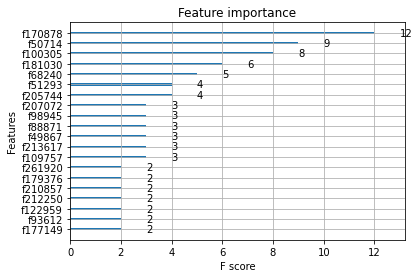

In [ ]:
# 绘图
from xgboost import plot_importance
from matplotlib import pyplot

xgb = XGBClassifier(subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0)
xgb.fit(x_train, y_train)

plot_importance(booster=xgb, max_num_features=20)
pyplot.show()